In [51]:
!pip install sentinelhub

- Create account on https://custom-scripts.sentinel-hub.com
- Get API key pair for your profile
- Create a configuration Utility
  - Here the `Configuration instance`
     will be the `instance_id`   

In [52]:
from kaggle_secrets import UserSecretsClient
user_secrets = UserSecretsClient()
sentinel_client_id = user_secrets.get_secret("sentinel_client_id")
sentinel_client_secret = user_secrets.get_secret("sentinel_client_secret")
sentinel_id = user_secrets.get_secret("sentinel_id")

# Configuration for SentinelHub
from sentinelhub import SHConfig
config = SHConfig()
config.instance_id = sentinel_id
config.sh_client_id = sentinel_client_id
config.sh_client_secret = sentinel_client_secret

# Get the Sentinel image:

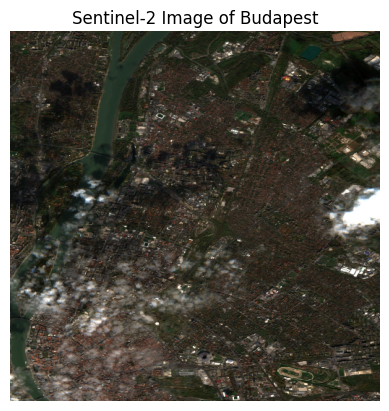

In [53]:
from sentinelhub import SHConfig, SentinelHubRequest, DataCollection, MimeType, CRS, BBox
import matplotlib.pyplot as plt
import numpy as np

# set coordinates
bbox = BBox(bbox=[19.04, 47.49, 19.15, 47.60], crs=CRS.WGS84)

# get the image
evalscript = """
//VERSION=3
function setup() {
    return {
        input: ["B04", "B03", "B02"],
        output: { bands: 3 }
    };
}

function evaluatePixel(sample) {
    return [sample.B04, sample.B03, sample.B02];
}
"""
def getImage(bbox):
    request = SentinelHubRequest(
        evalscript=evalscript,
        input_data=[
            SentinelHubRequest.input_data(
                data_collection=DataCollection.SENTINEL2_L2A,
                time_interval=('2024-10-01', '2024-10-31')
            )
        ],
        responses=[
            SentinelHubRequest.output_response('default', MimeType.TIFF)
        ],
        bbox=bbox,
        size=(512, 512),
        config=config
    )
    return request

request = getImage(bbox)
response = request.get_data()
image = response[0]

# set this to make the image brighter or darker. increase to make it darker
normalization_factor = 100  

# show the image
image = np.clip(image / normalization_factor, 0, 1)
plt.imshow(image)
plt.title('Sentinel-2 Image of Budapest')
plt.axis('off')
plt.show()

To zoom in/out change the `bbox` coordinates. These are: `[min_longitude, min_latitude, max_longitude, max_latitude]`.

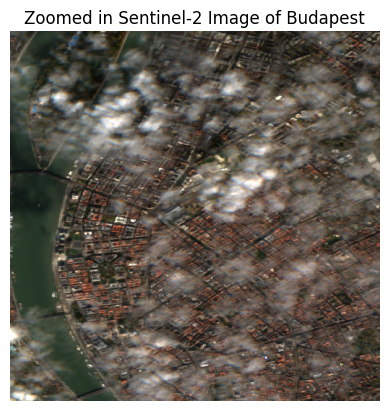

In [54]:
bbox = BBox(bbox=[19.04, 47.49, 19.08, 47.53], crs=CRS.WGS84)
request = getImage(bbox)
response = request.get_data()
image = response[0]

# set this to make the image brighter or darker. increase to make it darker
normalization_factor = 100  

# show the image
image = np.clip(image / normalization_factor, 0, 1)
plt.imshow(image)
plt.title('Zoomed in Sentinel-2 Image of Budapest')
plt.axis('off')
plt.show()

# Use interesting layers!

Use a collection of scripts, to see other interesting points on the satellite image!
https://custom-scripts.sentinel-hub.com/custom-scripts/

Now in this case below you can see how to filter out the water from the image!

## Water on satellite images

> The NDWI is used to monitor changes related to water content in water bodies. As water bodies strongly absorb light in visible to infrared electromagnetic spectrum, NDWI uses green and near infrared bands to highlight water bodies. It is sensitive to built-up land and can result in over-estimation of water bodies.
>
> $$NDWI = \frac{green-nir}{green+nir}$$
>
> Values description: Index values greater than 0.5 usually correspond to water bodies. Vegetation usually corresponds to much smaller values and built-up areas to values between zero and 0.2.
>
> more: https://custom-scripts.sentinel-hub.com/custom-scripts/hls/ndwi/



In [55]:
!pip install rasterio

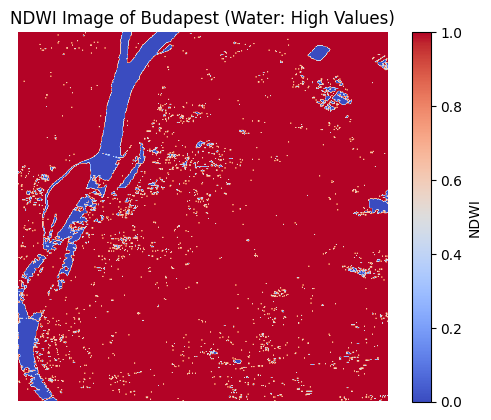

In [56]:
# Import necessary libraries
import rasterio
from sentinelhub import BBox, CRS, DataCollection, SentinelHubRequest, MimeType
import matplotlib.pyplot as plt
import numpy as np

# Set coordinates (Budapest area)
bbox = BBox(bbox=[19.04, 47.49, 19.15, 47.60], crs=CRS.WGS84)


# Function to calculate NDWI and visualize the image
def get_and_visualize_ndwi(bbox):
    # Sentinel Hub evalscript for NDWI calculation
    evalscript = """
    //VERSION=3
    function setup() {
        return {
            input: ["B08", "B02"],
            output: { bands: 1 }
        };
    }

    function evaluatePixel(sample) {
        // Calculate NDWI
        const ndwi = (sample.B08 - sample.B02) / (sample.B08 + sample.B02);
        return [ndwi];
    }
    """

    # Create Sentinel Hub request
    request = SentinelHubRequest(
        evalscript=evalscript,
        input_data=[
            SentinelHubRequest.input_data(
                data_collection=DataCollection.SENTINEL2_L2A,
                time_interval=('2024-10-01', '2024-10-31')
            )
        ],
        responses=[
            SentinelHubRequest.output_response('default', MimeType.TIFF)
        ],
        bbox=bbox,
        size=(512, 512),
        config=config
    )

    # Get data from Sentinel Hub
    response = request.get_data()
    ndwi_image = response[0]

    # Clip and normalize NDWI values
    ndwi_image = np.clip(ndwi_image, -1, 1)  # Ensure NDWI values are within valid range
    normalized_image = (ndwi_image - ndwi_image.min()) / (ndwi_image.max() - ndwi_image.min())

    # Visualize NDWI image
    plt.imshow(normalized_image, cmap='coolwarm')
    plt.title('NDWI Image of Budapest (Water: High Values)')
    plt.colorbar(label='NDWI')
    plt.axis('off')
    plt.show()

# Get and visualize NDWI image
get_and_visualize_ndwi(bbox)